In [11]:
import pyspark


In [12]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('taxi-time-price-prediction').getOrCreate()

In [ ]:
!wget -q https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-01.csv
!wget -q https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-02.csv
!wget -q https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-03.csv
!wget -q https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-04.csv
!wget -q https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-05.csv
!wget -q https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-06.csv
!wget -q https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv
!wget -q https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-02.csv
!wget -q https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-03.csv
!wget -q https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-04.csv
!wget -q https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-05.csv
!wget -q https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-06.csv
!wget -q https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2019-07.csv
!wget -q https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2019-08.csv
!wget -q https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2019-09.csv
!wget -q https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2019-10.csv
!wget -q https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2019-11.csv
!wget -q https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2019-12.csv

In [13]:
df = spark.read.csv('yellow_tripdata_2020-01.csv', header=True, sep=',', inferSchema=True)

for i in range(2, 7):
    new_df = spark.read.csv('yellow_tripdata_2020-0{}.csv'.format(str(i)), header=True, sep=',', inferSchema=True)
    df = df.union(new_df)

'''
df = spark.read.csv('yellow_tripdata_2019-01.csv', header=True, sep=',', inferSchema=True)
for i in range(2, 13):
    if i > 6:
        break
    if i < 10:
        new_df = spark.read.csv('yellow_tripdata_2019-0{}.csv'.format(str(i)), header=True, sep=',', inferSchema=True)
    else:
        new_df = spark.read.csv('yellow_tripdata_2019-{}.csv'.format(str(i)), header=True, sep=',', inferSchema=True)
    df = df.union(new_df)
'''
df_copy = df

In [14]:
#df = spark.read.csv('yellow_tripdata_2020-03.csv', header=True, sep=',', inferSchema=True)
import pyspark.sql.functions as f
df = df_copy
df = df.select(['tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'fare_amount'])
df = df.dropna(how = 'any')
df = df.withColumn('trip_total_distance', f.round(df['trip_distance']))
df.show(3)
desc_df = df.describe()

+---------------------+---------------+-------------+------------+------------+-----------+-------------------+
|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|fare_amount|trip_total_distance|
+---------------------+---------------+-------------+------------+------------+-----------+-------------------+
|  2020-01-01 00:33:03|              1|          1.2|         238|         239|        6.0|                1.0|
|  2020-01-01 00:43:04|              1|          1.2|         239|         238|        7.0|                1.0|
|  2020-01-01 00:53:52|              1|          0.6|         238|         238|        6.0|                1.0|
+---------------------+---------------+-------------+------------+------------+-----------+-------------------+
only showing top 3 rows



In [15]:
#print(df.dtypes)
#desc_df.show()
df = df[df.fare_amount > 1]
df = df[df.trip_distance > 1]
df = df[df.trip_distance < 35]
df = df[df.passenger_count > 0]

df = df.withColumn('day_of_week', f.dayofweek(df['tpep_dropoff_datetime']))
df = df.withColumn('hour_of_day', f.hour(df['tpep_dropoff_datetime']))

df_hour = df.groupBy('hour_of_day').count()
most_active_hours = df_hour.sort(['count'], ascending=False)
most_active_hours.show(25)
most_active_hours = most_active_hours.limit(12)

df_day_of_week = df.groupBy('day_of_week').count()
most_active_days_of_week = df_day_of_week.sort(['count'], ascending=False)
most_active_days_of_week.show()
most_active_days_of_week = most_active_days_of_week.limit(4)


hours = most_active_hours.select('hour_of_day')
days = most_active_days_of_week.select('day_of_week')

from pyspark.sql.functions import lit, when

from pyspark.sql.functions import lit, when    # to add a column filled with a constant value
days_list = set([int(row.day_of_week) for row in days.collect()])
print(days_list)
hours_list = set([int(row.hour_of_day) for row in hours.collect()])
print(hours_list)
df = df.withColumn('active_day_of_week',when(df.day_of_week.isin(days_list), 1).otherwise(0))
df = df.withColumn('active_hour_of_day',when(df.hour_of_day.isin(hours_list), 1).otherwise(0))
df.show()

df = df.select(['passenger_count', 'trip_distance', 'active_day_of_week', 'active_hour_of_day','PULocationID','DOLocationID', 'fare_amount'])
df.where(df['active_day_of_week'] > 0).show()
df.show()


+-----------+------+
|hour_of_day| count|
+-----------+------+
|         18|805477|
|         19|766386|
|         17|705854|
|         15|669778|
|         20|667745|
|         21|661154|
|         16|644848|
|         22|630899|
|         14|630378|
|         13|597959|
|         12|589734|
|         11|546579|
|          9|543770|
|         10|538009|
|          8|515118|
|         23|496721|
|          7|388704|
|          0|360487|
|          1|250194|
|          6|208320|
|          2|173407|
|          3|123971|
|          4| 95703|
|          5| 92304|
+-----------+------+

+-----------+-------+
|day_of_week|  count|
+-----------+-------+
|          5|1872842|
|          6|1855063|
|          4|1803905|
|          7|1641785|
|          3|1618998|
|          2|1478428|
|          1|1432478|
+-----------+-------+

{4, 5, 6, 7}
{11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}
+---------------------+---------------+-------------+------------+------------+-----------+---------------

In [16]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=df.columns[0:6], outputCol="features")
df_vec = assembler.transform(df)
df_vec.show()
df_train, df_test = df_vec.randomSplit([0.7, 0.3])
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol='features', labelCol='fare_amount') 
lr_model = lr.fit(df_train)
evaluation_summary = lr_model.evaluate(df_test)
evaluation_summary.predictions.where(df['trip_distance'] > 10).show()

+---------------+-------------+------------------+------------------+------------+------------+-----------+--------------------+
|passenger_count|trip_distance|active_day_of_week|active_hour_of_day|PULocationID|DOLocationID|fare_amount|            features|
+---------------+-------------+------------------+------------------+------------+------------+-----------+--------------------+
|              1|          1.2|                 1|                 0|         238|         239|        6.0|[1.0,1.2,1.0,0.0,...|
|              1|          1.2|                 1|                 0|         239|         238|        7.0|[1.0,1.2,1.0,0.0,...|
|              2|          2.4|                 1|                 0|         246|          79|       12.0|[2.0,2.4,1.0,0.0,...|
|              1|          3.3|                 1|                 0|         161|         144|       17.0|[1.0,3.3,1.0,0.0,...|
|              1|         1.07|                 1|                 0|          43|         239|  

In [18]:
print(df.count())

11703499


In [17]:
print(evaluation_summary.rootMeanSquaredError)
print(evaluation_summary.meanSquaredError)
#print(evaluation_summary.accuracy)

4.0156072275787675
16.12510140618284


+---------------+-------------+------------------+------------------+------------+------------+-----------+--------------------+------------------+
|passenger_count|trip_distance|active_day_of_week|active_hour_of_day|PULocationID|DOLocationID|fare_amount|            features|        prediction|
+---------------+-------------+------------------+------------------+------------+------------+-----------+--------------------+------------------+
|              1|         1.01|                 1|                 0|          24|          75|        6.0|[1.0,1.01,1.0,0.0...|  7.36079809327256|
|              1|         1.01|                 1|                 0|          43|         161|        5.0|[1.0,1.01,1.0,0.0...| 7.343561759984059|
|              1|         1.01|                 1|                 0|          48|          43|        6.5|[1.0,1.01,1.0,0.0...| 7.387921026841302|
|              1|         1.01|                 1|                 0|          48|         100|        5.5|[1.0,

<AxesSubplot:>

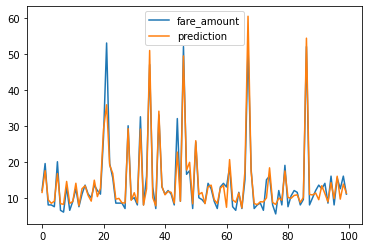

In [19]:
predictions_df = evaluation_summary.predictions
predictions_df.show()
predictions_df = predictions_df.orderBy(f.rand()).limit(100)
import matplotlib.pyplot as plt
plt.close('all')
print(type(predictions_df))
predictions_df = predictions_df.toPandas()
predictions_df.plot(y=["fare_amount", "prediction"])


<AxesSubplot:xlabel='hour_of_day'>

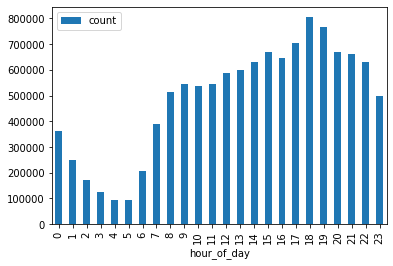

In [20]:
df_day_of_week_pd = df_day_of_week.toPandas()
df_hour_pd = df_hour.toPandas()
df_hour_pd = df_hour_pd.sort_values(by='hour_of_day')
df_hour_pd.plot(x="hour_of_day", y="count", kind="bar")

<AxesSubplot:xlabel='day_of_week'>

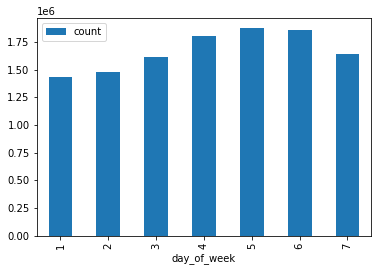

In [21]:
df_day_of_week_pd = df_day_of_week_pd.sort_values(by='day_of_week')
df_day_of_week_pd.plot(x="day_of_week", y="count", kind="bar")

<AxesSubplot:xlabel='PULocationID'>

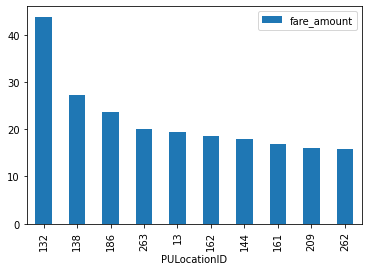

In [22]:
pickup_groupby_pd = predictions_df.groupby('PULocationID').mean('fare_amount').sort_values(by='fare_amount', ascending=False).head(10)
pickup_groupby_pd.reset_index().plot(x="PULocationID", y="fare_amount", kind="bar")

<AxesSubplot:xlabel='DOLocationID'>

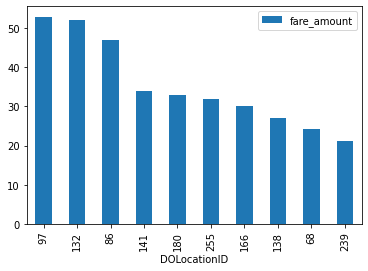

In [23]:
dropoff_groupby_pd = predictions_df.groupby('DOLocationID').mean('fare_amount').sort_values(by='fare_amount', ascending=False).head(10)
dropoff_groupby_pd.reset_index().plot(x="DOLocationID", y="fare_amount", kind="bar")

                 trip_distance  active_day_of_week  active_hour_of_day  \
passenger_count                                                          
1                          742                 742                 742   
2                          143                 143                 143   
3                           37                  37                  37   
4                           20                  20                  20   
5                           40                  40                  40   
6                           18                  18                  18   

                 PULocationID  DOLocationID  fare_amount  features  prediction  
passenger_count                                                                 
1                         742           742          742       742         742  
2                         143           143          143       143         143  
3                          37            37           37        37          37  
4 

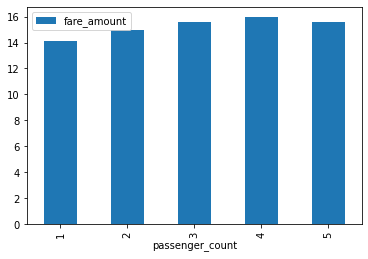

In [33]:
dropoff_groupby_pd = predictions_df.groupby('passenger_count').mean('fare_amount').sort_values(by='passenger_count').head(5)
dropoff_groupby_pd.reset_index().plot(x="passenger_count", y="fare_amount", kind="bar")


In [34]:
print(predictions_df.groupby('passenger_count').count())

                 trip_distance  active_day_of_week  active_hour_of_day  \
passenger_count                                                          
1                          742                 742                 742   
2                          143                 143                 143   
3                           37                  37                  37   
4                           20                  20                  20   
5                           40                  40                  40   
6                           18                  18                  18   

                 PULocationID  DOLocationID  fare_amount  features  prediction  
passenger_count                                                                 
1                         742           742          742       742         742  
2                         143           143          143       143         143  
3                          37            37           37        37          37  
4 

In [2]:
predictions_df = evaluation_summary.predictions
predictions_df.show()
predictions_df = predictions_df.orderBy(f.rand()).limit(1000)
import matplotlib.pyplot as plt
plt.close('all')
print(type(predictions_df))
predictions_df = predictions_df.toPandas()
predictions_df.plot(x ="fare_amount", y ="prediction")

'predictions_df = evaluation_summary.predictions\npredictions_df.show()\npredictions_df = predictions_df.orderBy(f.rand()).limit(1000)\nimport matplotlib.pyplot as plt\nplt.close(\'all\')\nprint(type(predictions_df))\npredictions_df = predictions_df.toPandas()\npredictions_df.plot(x ="fare_amount", y ="prediction")\nprint()'